In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import datetime
import warnings
#warnings.simplefilter("ignore", FutureWarning)  # openml deprecation of array return type
warnings.simplefilter("ignore", UserWarning)  # scikit-learn select k best

from ticl.datasets import load_openml_list, open_cc_valid_dids_regression 
from ticl.evaluation.baselines.tabular_baselines import knn_metric, catboost_metric, logistic_metric, xgb_metric, random_forest_metric, mlp_metric, hyperfast_metric, ridge_metric, mlp_sklearn_metric
from ticl.evaluation.tabular_evaluation import evaluate, eval_on_datasets, transformer_metric
from ticl.evaluation import tabular_metrics
from ticl.prediction.tabpfn import TabPFNClassifier
from ticl.evaluation.baselines import tabular_baselines

# Datasets

In [2]:
from ticl.datasets import load_openml_list, open_cc_dids, open_cc_valid_dids, test_dids_classification

cc_valid_datasets_regression, cc_valid_datasets_regression_df = load_openml_list(open_cc_valid_dids_regression, classification=False, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = 10000, num_feats=100, return_capped=True)


/home/amueller/public/TabPFN/mothernet/datasets/__init__.py:153: FutureWarning: Support for `output_format` of 'dict' will be removed in 0.15 and pandas dataframes will be returned instead. To ensure your code will continue to work, use `output_format`='dataframe'.
  openml_list = openml.datasets.list_datasets(dids)


Number of datasets: 11


In [3]:
cc_valid_datasets_regression_df['NumberOfInstances'] =  cc_valid_datasets_regression_df['NumberOfInstances'].astype(int)
cc_valid_datasets_regression_df['NumberOfFeatures'] =  cc_valid_datasets_regression_df['NumberOfFeatures'].astype(int)
cc_valid_datasets_regression_df['NumberOfClasses'] =  cc_valid_datasets_regression_df['NumberOfClasses'].astype(int)

# uncomment for latex table of datasets
# print(cc_valid_datasets_multiclass_df[['did', 'name', 'NumberOfFeatures', 'NumberOfInstances', 'NumberOfClasses']].rename(columns={'NumberOfFeatures': "d", "NumberOfInstances":"n", "NumberOfClasses": "k"}).to_latex(index=False))

In [4]:
cc_valid_datasets_regression_df

,did,name,version,uploader,status,format,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures,MaxNominalAttDistinctValues
8,8,liver-disorders,1,1,active,ARFF,0,6,345,0.0,0.0,6.0,0.0,NaN
189,189,kin8nm,1,1,active,ARFF,0,9,8192,0.0,0.0,9.0,0.0,NaN
194,194,cleveland,1,1,active,ARFF,0,14,303,6.0,6.0,7.0,7.0,4.0
198,198,delta_elevators,1,1,active,ARFF,0,7,9517,0.0,0.0,7.0,0.0,NaN
204,204,cholesterol,1,1,active,ARFF,0,14,303,6.0,6.0,7.0,7.0,4.0
210,210,cloud,1,1,active,ARFF,0,6,108,0.0,0.0,4.0,2.0,4.0
507,507,space_ga,1,2,active,ARFF,0,7,3107,0.0,0.0,7.0,0.0,NaN
560,560,bodyfat,1,2,active,ARFF,0,15,252,0.0,0.0,15.0,0.0,NaN
562,562,cpu_small,2,2,active,ARFF,0,13,8192,0.0,0.0,13.0,0.0,NaN
566,566,meta,1,2,active,ARFF,0,22,528,264.0,504.0,20.0,2.0,24.0


# Setting params

In [5]:
import os
eval_positions = [1000]
max_features = 100
n_samples = 2000
base_path = os.path.join('..')
overwrite = False
metric_used = tabular_metrics.root_mean_squared_error_metric
task_type = 'regression'
classification = False

# Baseline Evaluation
This section runs baselines and saves results locally.

In [6]:
!mkdir -p {base_path}/results
!mkdir -p {base_path}/results/tabular/
!mkdir -p {base_path}/results/tabular/regression/

In [8]:
len(cc_valid_datasets_regression)

11

In [10]:
# max_times = [1, 5, 15, 60, 5 * 60, 15 * 60, 60* 60]
max_times = [1]
# these will all be evaluated on CPU because they are given as  callables, which is a weird way to do it.
clf_dict= {
    'knn': knn_metric,
    'rf_new_params': random_forest_metric,
    'xgb': xgb_metric,
    'ridge': ridge_metric,
    'mlp_sklearn_metric': mlp_sklearn_metric,
}

results_baselines = [
    eval_on_datasets('regression', model, model_name, cc_valid_datasets_regression, eval_positions=eval_positions, max_times=max_times,
                     metric_used=metric_used, split_numbers=[1, 2, 3, 4, 5],
                     n_samples=n_samples, base_path=base_path, n_jobs=1, verbose=0)
    for model_name, model in clf_dict.items()
]

evaluating knn on cpu
evaluating rf_new_params on cpu
evaluating xgb on cpu
evaluating ridge on cpu
evaluating mlp_sklearn_metric on cpu


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


In [38]:
from ticl.evaluation.tabular_evaluation import eval_on_datasets
from ticl.prediction.mothernet import ShiftClassifier, EnsembleMeta, MotherNetClassifier, MotherNetInitMLPClassifier
from ticl.prediction.mothernet_additive import MotherNetAdditiveRegressor
from ticl.evaluation.baselines.distill_mlp import DistilledTabPFNMLP
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from interpret.glassbox import ExplainableBoostingRegressor
from functools import partial
#from hyperfast import HyperFastClassifier

# transformers don't have max times
max_times = [1]
device = "cpu"

ebm_default = ExplainableBoostingRegressor()
ebm_bins = ExplainableBoostingRegressor(max_bins=64)
ebm_bins_main_effects = ExplainableBoostingRegressor(max_bins=64, interactions=0)


baam_yencoderlinear_05_08_2024_03_04_01_e490 = MotherNetAdditiveRegressor(path="../models_diff/baam_Daverage_l1e-05_maxnumclasses0_nsamples500_numfeatures10_yencoderlinear_05_08_2024_03_04_01_epoch_420.cpkt", device=device)


#hyperfast_no_optimization = HyperFastClassifier(device=device, optimization=None)
#hyperfast_defaults = HyperFastClassifier(device=device)

clf_dict= {
    "baam_yencoderlinear_05_08_2024_03_04_01_e490": baam_yencoderlinear_05_08_2024_03_04_01_e490,
    'ebm_default': partial(transformer_metric, classifier=ebm_default),
    'ebm_bins': partial(transformer_metric, classifier=ebm_bins),
    'ebm_bins_main_effects': partial(transformer_metric, classifier=ebm_bins_main_effects),
    }
results_transformers = [
    eval_on_datasets('regression', model, model_name, cc_valid_datasets_regression, eval_positions=eval_positions, max_times=max_times,
                     metric_used=metric_used, split_numbers=[1, 2, 3, 4, 5],
                     n_samples=n_samples, base_path=base_path, overwrite=False, n_jobs=1, device=device, verbose=10)
    for model_name, model in clf_dict.items()
]

evaluating baam_yencoderlinear_05_08_2024_03_04_01_e490 on cpu
Evaluating liver-disorders with 345 samples
Evaluating liver-disorders with 345 samples
Evaluating liver-disorders with 345 samples
Evaluating liver-disorders with 345 samples
Evaluating liver-disorders with 345 samples
Evaluating kin8nm with 8192 samples
Evaluating kin8nm with 8192 samples
Evaluating kin8nm with 8192 samples
Evaluating kin8nm with 8192 samples
Evaluating kin8nm with 8192 samples
Evaluating cleveland with 303 samples
Evaluating cleveland with 303 samples
Evaluating cleveland with 303 samples
Evaluating cleveland with 303 samples
Evaluating cleveland with 303 samples
Evaluating delta_elevators with 9517 samples
Evaluating delta_elevators with 9517 samples
Evaluating delta_elevators with 9517 samples
Evaluating delta_elevators with 9517 samples
Evaluating delta_elevators with 9517 samples
Evaluating cholesterol with 303 samples
Evaluating cholesterol with 303 samples
Evaluating cholesterol with 303 samples
Ev

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   42.5s


Evaluating cpu_small with 8192 samples
Evaluating cpu_small with 8192 samples
Evaluating cpu_small with 8192 samples
Evaluating cpu_small with 8192 samples
Evaluating cpu_small with 8192 samples
Evaluating meta with 528 samples
Evaluating meta with 528 samples
Evaluating meta with 528 samples
Evaluating meta with 528 samples
Evaluating meta with 528 samples
Evaluating NASA_PHM2008 with 10000 samples
Evaluating NASA_PHM2008 with 10000 samples
Evaluating NASA_PHM2008 with 10000 samples
Evaluating NASA_PHM2008 with 10000 samples
Evaluating NASA_PHM2008 with 10000 samples
evaluating ebm_default on cpu
Evaluating liver-disorders with 345 samples
Evaluating liver-disorders with 345 samples
Evaluating liver-disorders with 345 samples
Evaluating liver-disorders with 345 samples
Evaluating liver-disorders with 345 samples
Evaluating kin8nm with 8192 samples
Evaluating kin8nm with 8192 samples
Evaluating kin8nm with 8192 samples
Evaluating kin8nm with 8192 samples
Evaluating kin8nm with 8192 sam

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


In [39]:
flat_results = []
for per_dataset in results_baselines + results_transformers:
    for result in per_dataset:
        row = {}
        for key in ['dataset', 'model', 'mean_metric', 'split', 'max_time']:
            row[key] = result[key]
        best_configs_key, = [k for k in result.keys() if "best_configs" in k]
        if result[best_configs_key][0] is not None:
            row.update(result[best_configs_key][0])
        row['mean_metric'] = float(row["mean_metric"].numpy())
        flat_results.append(row)

results_df = pd.DataFrame(flat_results)

In [40]:
results_df

,dataset,model,mean_metric,split,max_time,best,fit_time,inference_time
0,liver-disorders,knn,3.154293,1,1,{'n_neighbors': 15},0.000364,0.002685
1,liver-disorders,knn,2.823169,2,1,{'n_neighbors': 9},0.000296,0.000833
2,liver-disorders,knn,2.895466,3,1,{'n_neighbors': 14},0.000314,0.000963
3,liver-disorders,knn,3.214827,4,1,{'n_neighbors': 6},0.000283,0.000803
4,liver-disorders,knn,3.031209,5,1,{'n_neighbors': 8},0.000303,0.000867
...,...,...,...,...,...,...,...,...
490,NASA_PHM2008,ebm_bins_main_effects,43.519657,1,1,NaN,0.312180,0.000754
491,NASA_PHM2008,ebm_bins_main_effects,42.324421,2,1,NaN,0.301805,0.000764
492,NASA_PHM2008,ebm_bins_main_effects,42.372948,3,1,NaN,0.285389,0.000813
493,NASA_PHM2008,ebm_bins_main_effects,43.298302,4,1,NaN,0.321082,0.000818


In [41]:
results_df.model.unique()

array(['knn', 'rf_new_params', 'xgb', 'ridge', 'mlp_sklearn_metric',
       'baam_yencoderlinear_05_08_2024_03_04_01_e490', 'ebm_default',
       'ebm_bins', 'ebm_bins_main_effects'], dtype=object)

In [42]:
filename = f"results_validation_regression{datetime.date.today()}.csv"
results_df.to_csv(filename)
filename

'results_validation_regression2024-05-13.csv'

In [43]:
valid_results = results_df

In [46]:
def compare_splits(results):
    compare_splits_over_time = results.groupby(["model", "split", "max_time"])[['mean_metric', 'fit_time']].mean().reset_index()
    compare_splits_over_time_last = compare_splits_over_time[compare_splits_over_time.max_time == compare_splits_over_time.max_time.max()]
    return compare_splits_over_time, compare_splits_over_time_last
    
def normalize_metric(results):
    dataset_min_max = results.groupby("dataset").mean_metric.agg(["min", "max"])
    results_normalized = results.merge(dataset_min_max, on="dataset")
    results_normalized['mean_metric'] = (results_normalized['mean_metric'] - results_normalized['min']) / (results_normalized['max'] - results_normalized['min'])
    return results_normalized

compare_splits_over_time_valid_normalized, compare_splits_valid_normalized = compare_splits(normalize_metric(valid_results))


<Axes: xlabel='mean_metric', ylabel='model'>

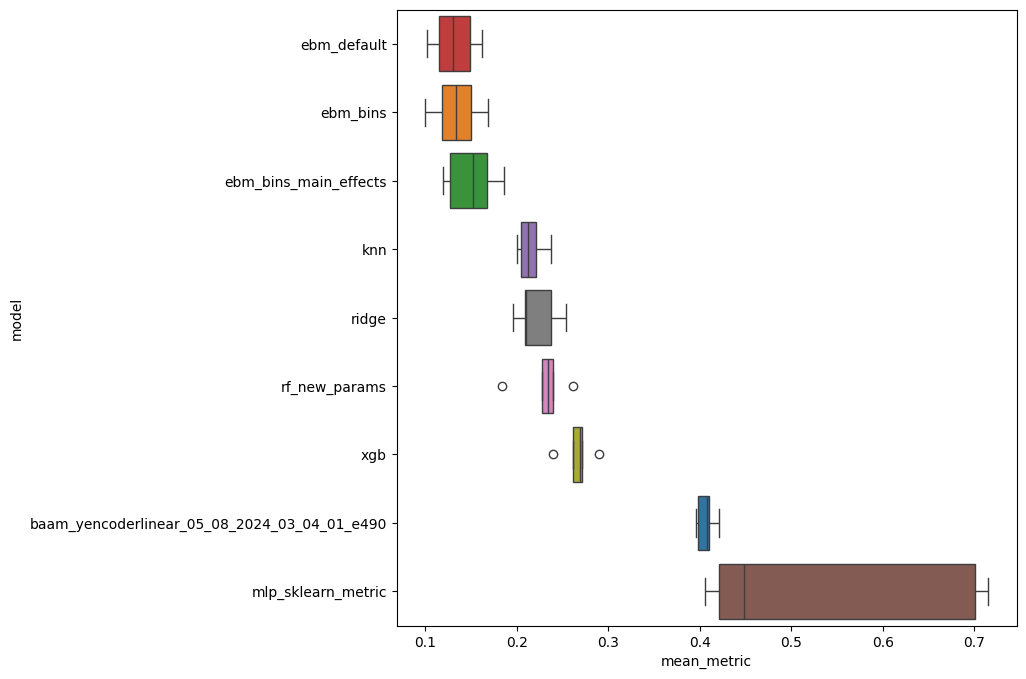

In [50]:
plt.figure(figsize=(8, 8))
order = compare_splits_over_time_valid_normalized.groupby("model").mean("mean_metric").sort_values("mean_metric").index
sns.boxplot(data=compare_splits_over_time_valid_normalized, y="model", x="mean_metric", order=order, ax=plt.gca(), hue="model")
#sns.boxplot(data=compare_splits_valid, y="model", x="mean_metric",order=order, ax=plt.gca(), hue="model")

In [56]:
cc_valid_datasets_multiclass_df.set_index("name").loc['analcatdata_reviewer']

did                                      460
version                                    1
uploader                                   2
status                                active
format                                  ARFF
MajorityClassSize                      141.0
MaxNominalAttDistinctValues              3.0
MinorityClassSize                       54.0
NumberOfClasses                            4
NumberOfFeatures                           8
NumberOfInstances                        379
NumberOfInstancesWithMissingValues     365.0
NumberOfMissingValues                 1418.0
NumberOfNumericFeatures                  0.0
NumberOfSymbolicFeatures                 8.0
Name: analcatdata_reviewer, dtype: object

In [57]:
cc_valid_datasets_multiclass_df.set_index("name").loc['pbc']

did                                      810
version                                    3
uploader                                   2
status                                active
format                                  ARFF
MajorityClassSize                      230.0
MaxNominalAttDistinctValues              4.0
MinorityClassSize                      188.0
NumberOfClasses                            2
NumberOfFeatures                          19
NumberOfInstances                        418
NumberOfInstancesWithMissingValues     142.0
NumberOfMissingValues                 1239.0
NumberOfNumericFeatures                 10.0
NumberOfSymbolicFeatures                 9.0
Name: pbc, dtype: object

In [62]:
cc_valid_datasets_multiclass_df.set_index("name").loc['chscase_vine2']

did                                      814
version                                    2
uploader                                   2
status                                active
format                                  ARFF
MajorityClassSize                      256.0
MaxNominalAttDistinctValues              2.0
MinorityClassSize                      212.0
NumberOfClasses                            2
NumberOfFeatures                           3
NumberOfInstances                        468
NumberOfInstancesWithMissingValues       0.0
NumberOfMissingValues                    0.0
NumberOfNumericFeatures                  2.0
NumberOfSymbolicFeatures                 1.0
Name: chscase_vine2, dtype: object

In [64]:
import dabl
from sklearn.datasets import fetch_openml
data = fetch_openml("chscase_vine2")

In [76]:
_, X, y, *bla = [x for x in cc_valid_datasets_multiclass if x[0] == 'chscase_vine2'][0]

Target looks like regression


[<AxesSubplot: title={'center': 'Target distribution'}, xlabel='col_3', ylabel='frequency'>,
 array([[<AxesSubplot: title={'center': 'F=-7.47E-02'}, xlabel='col_2', ylabel='col_3'>,
         <AxesSubplot: title={'center': 'F=6.46E-02'}, xlabel='col_1 (jittered)'>]],
       dtype=object),
 None]

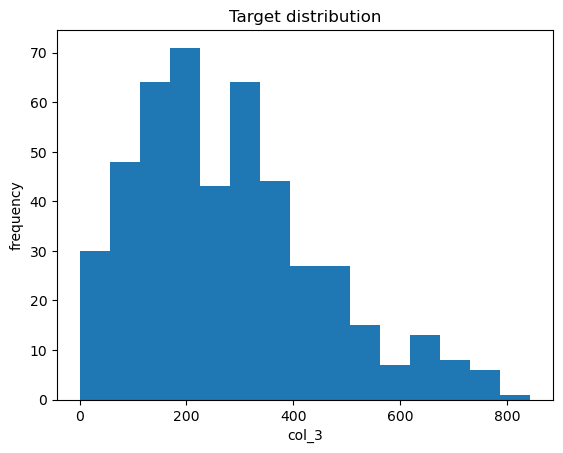

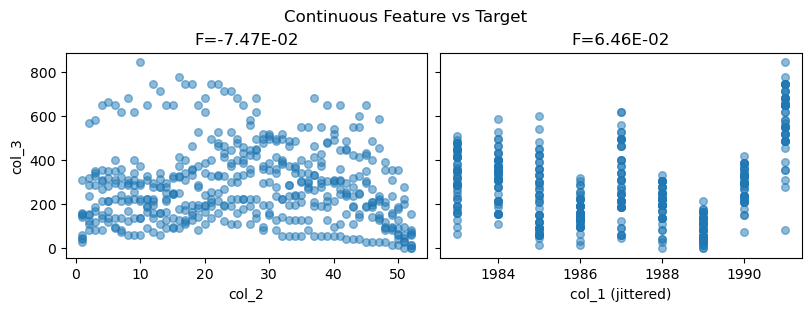

In [67]:
dabl.plot(data.frame, target_col=data.target_names[0])

<AxesSubplot: xlabel='col_1', ylabel='col_2'>

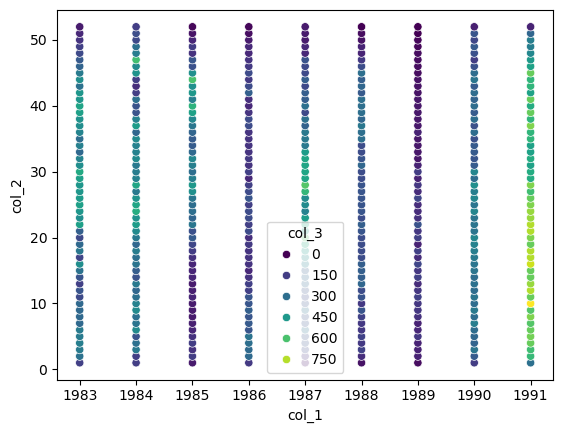

In [82]:
import seaborn as sns
sns.scatterplot(data=data.frame, x="col_1", y="col_2", hue="col_3", palette="viridis")

<AxesSubplot: xlabel='col_3', ylabel='col_2'>

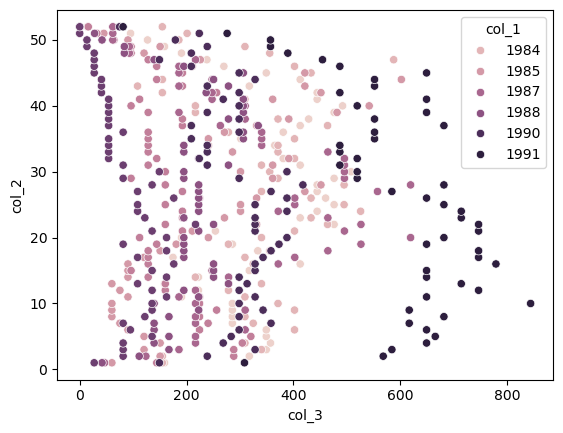

Bad pipe message: %s [b'\x8b\xfa\xf1\xc7\xe0M\xceX\xaf\x8f)\x80Qx\x11\x14\xee\x13 \xb4p\xe8\xef\x95\x1e6g5|]H}K\x89\x86\xfa)\xdf\x83\xa7yC\xf9%q\xf99y\xcc\xb3\x01\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19']
Bad pipe message: %s [b'T\x92*\x8a\x10A\x06\xac-\xea\xc2\x0b\x80\x08\xd3ye"\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0s\xc0w\x00\xc4\x00\xc3\xc0#\xc0\'\x00g\x00@\xc0r\xc0v\x00\xbe\x00\xbd\xc0\n\xc0\x14\x009\x008\x00\x88\x00\x87\xc0\t\xc0\x13\x003\x002\x00\x9a\x00\x99\x00E\x00D\xc0\x07\xc0\x11\xc0\x08\xc0\x12\x00\x16\x00\x13\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00\xc0\x00<\x00\xba\x005\x00\x84\x00/\x00\x96']
Bad pipe message: %s [b'\x8b/6=\xcf\xdf[

In [83]:
sns.scatterplot(data=data.frame, x="col_3", y="col_2", hue="col_1")

Target looks like classification
Linear Discriminant Analysis training set score: 0.497


[<AxesSubplot: title={'center': 'Target distribution'}, xlabel='count', ylabel='target'>,
 [array([[<AxesSubplot: ylabel='0'>, <AxesSubplot: >],
         [<AxesSubplot: xlabel='0', ylabel='1'>, <AxesSubplot: xlabel='1'>]],
        dtype=object),
  <Figure size 800x400 with 2 Axes>,
  <Figure size 640x480 with 1 Axes>],
 None]

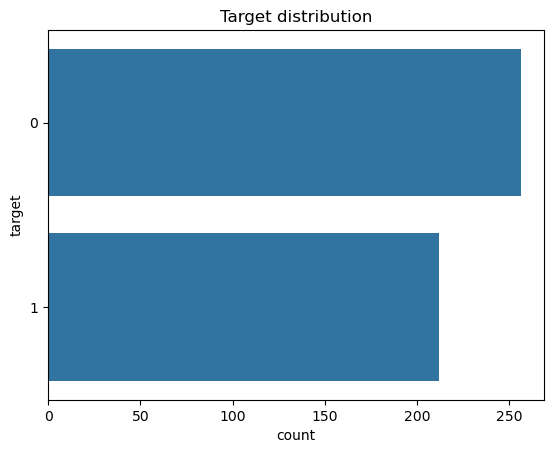

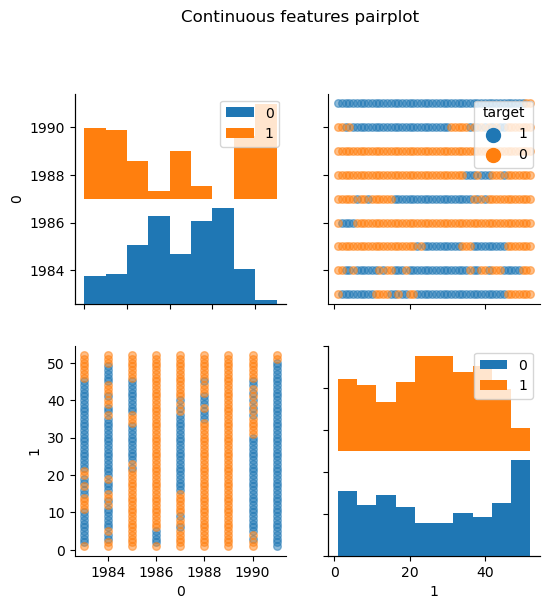

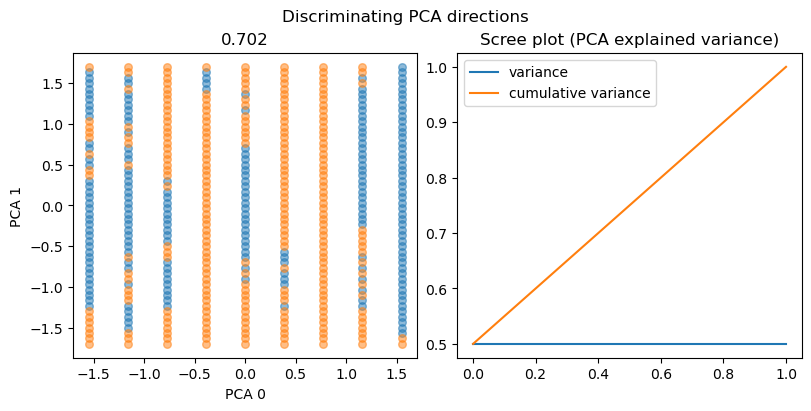

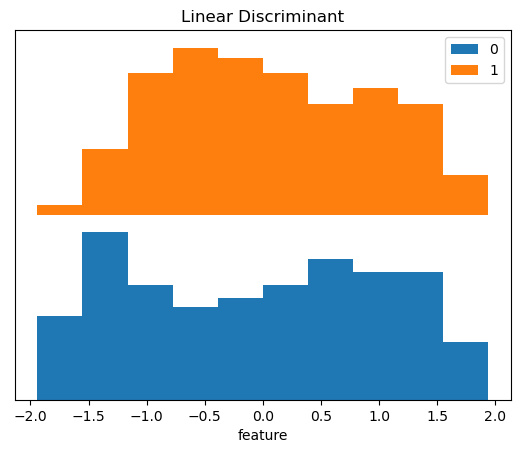

In [77]:
dabl.plot(X, y=y)